## Convolutional Neural Network exploration

In the following notebook I will build in image classifier conv net that tries to separate dogs from cats. I will use augmentation for training, and first I will train my own convnet, after which I will leverage a pre-trained model (transfer learning)

<img src='https://miro.medium.com/max/2510/1*vkQ0hXDaQv57sALXAJquxA.jpeg' width = 650>

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import time

import warnings
warnings.filterwarnings('ignore')

### Exploring our images, how they can be represented in a ConvNet

Some of our dogs

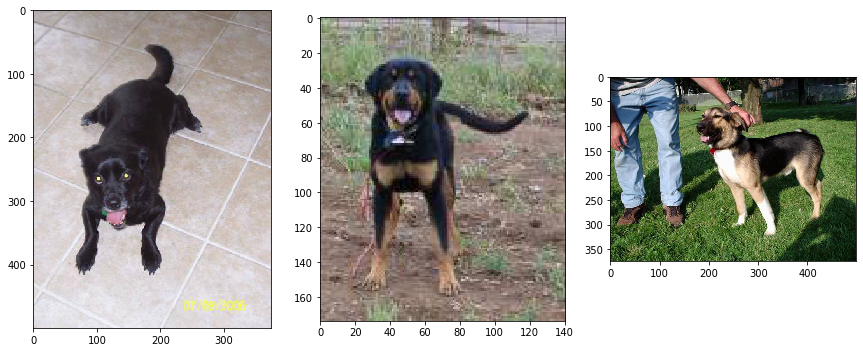

In [3]:
k = 0
plt.figure(figsize = (12, 5))

for i, dog_image in enumerate(os.listdir('data/train/dogs/')[85:88]):
    
    k += 1
    
    plt.subplot(1, 3, k)
    plt.imshow(plt.imread('data/train/dogs/' + dog_image))
    plt.tight_layout()

Some of our cats

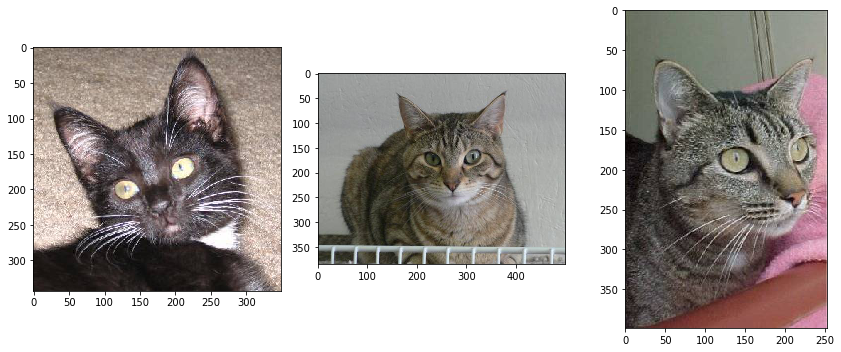

In [4]:
k = 0
plt.figure(figsize = (12, 5))

for i, dog_image in enumerate(os.listdir('data/train/cats/')[5:8]):
    
    k += 1
    
    plt.subplot(1, 3, k)
    plt.imshow(plt.imread('data/train/cats/' + dog_image))
    plt.tight_layout()

#### Every ML model needs numbers, not text, not images... So let's represent out photos as numbers

We will have 3 dimensions for 1 image
1. Height (x pixels)
2. Width (y pixels)
3. Color channels (3 - red, green, blue)

This will make every image represented as a x * y * 3 tensor

In [5]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


Let's work with this image to see how we go from photo to numbers

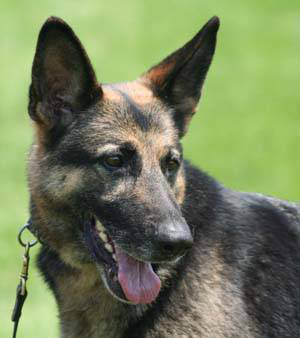

In [6]:
i = load_img('data/train/dogs/dog_311.jpg')
i

Here's the above photo represented in tensor form: 
1. Height = 338 pixels
2. Width = 300 pixels
3. Color channels = 3

In [7]:
x = img_to_array(i)
x.shape

(338, 300, 3)

Here's the above photo in grayscale, by averaging the 3rd dimension (colors)

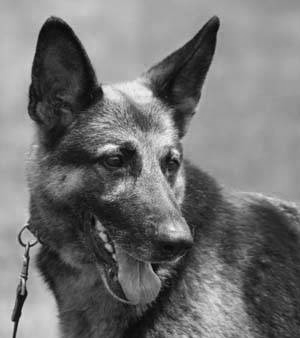

In [8]:
array_to_img(np.reshape(np.mean(x, axis = 2), (338, 300, 1)))

We can also print the image as its 3 color channels represent it

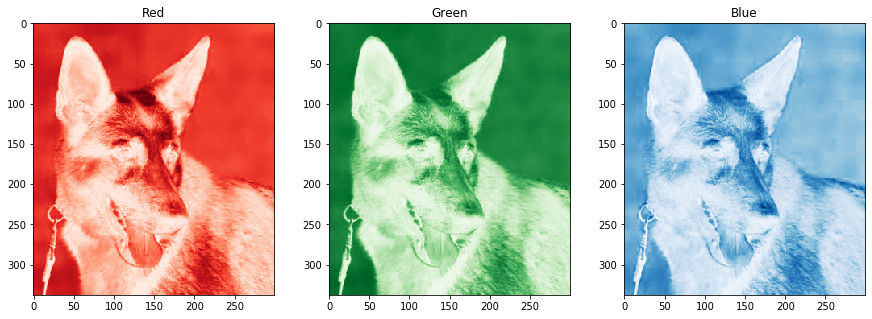

In [9]:
fig, ax = plt.subplots(figsize = (15, 5), ncols = 3, nrows = 1)

ax[0].imshow(x[:,:,0], cmap = 'Reds')
ax[1].imshow(x[:,:,1], cmap = 'Greens')
ax[2].imshow(x[:,:,2], cmap = 'Blues')

ax[0].title.set_text('Red')
ax[1].title.set_text('Green')
ax[2].title.set_text('Blue')

fig.show()

Finally we will need to *mark* our 4th dimension: the index of the image. This way we can represent everything in a 4-dimensional tensor
1. Image index
2. Height
3. Width
4. Color channels

In [10]:
print('Every image will have a similar representation in the model:')
print(x.reshape((1,) + x.shape).shape)

Every image will have a similar representation in the model:
(1, 338, 300, 3)


Of course there's one more thing to take care of. We cannot have images of separate sizes. The model needs a constant input, just as it is required by us to give us a constant (sized) output. We can set the desired size in the img_load function

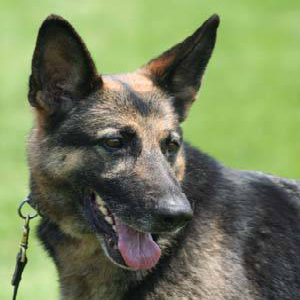

In [11]:
i = load_img('data/train/dogs/dog_311.jpg', target_size = (300, 300))
i

#### Creating image flow for ConvNet input

We can use the ImageDataGenerator() function to set up a flow, where each photo will be given to the model after it's been processed a little bit. For model generalization it is good practice to use data augmentation (random changes to the image so that the model can better perform on brand new data). During augmentation we can
1. Resize
2. Rotate
3. Zoom
4. Move
5. etc, etc...

One thing we need to take into consideration is validation. We need to **perform augmentation on train set** but the **validation set must remain unchanged** as we're training on more generalized images, but validating on real photos. Therefore we need to create to flow recipes, one for training, one for validation. I also have a final dataset for final testing, that will also need to be untouched

In [84]:
train_gen = ImageDataGenerator(rotation_range = 40,
                               width_shift_range = 0.2,
                               height_shift_range = 0.2,
                               rescale = 1./255,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               horizontal_flip = True)

valid_gen = ImageDataGenerator(rescale = 1./255)
test_gen = ImageDataGenerator(rescale = 1./255)

train_generator = train_gen.flow_from_directory('data/train/', batch_size = 32, class_mode = 'binary', target_size = (300, 300))
valid_generator = valid_gen.flow_from_directory('data/validation/', batch_size = 32, class_mode = 'binary', target_size = (300, 300))
test_generator = test_gen.flow_from_directory('data/test/', batch_size = 32, class_mode = 'binary', target_size = (300, 300), shuffle = False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [13]:
print('Every image will be read in in the following format:', train_generator.image_shape)
print('Our classes will be the following:', train_generator.class_indices)

Every image will be read in in the following format: (300, 300, 3)
Our classes will be the following: {'cats': 0, 'dogs': 1}


### We can basically start building our ConvNet

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.regularizers import l1, l2
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from livelossplot import PlotLossesKeras

In [17]:
IMG_SHAPE = train_generator.image_shape 
BATCH_SIZE = train_generator.batch_size
NB_TRAIN_IMG = train_generator.n
NB_VALID_IMG = valid_generator.n

print('Our images will be of shape', IMG_SHAPE, '\nWe will train with batches of size', BATCH_SIZE, 'and we will have', NB_TRAIN_IMG, 'images for training and', NB_VALID_IMG, 'images for validation')

Our images will be of shape (300, 300, 3) 
We will train with batches of size 32 and we will have 2000 images for training and 1000 images for validation


In [18]:
model = Sequential(name = 'Simple CNN', )

model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', input_shape = IMG_SHAPE, data_format = 'channels_last', activation = 'relu'))
model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(GlobalAveragePooling2D()) # flatten would make the model train 23mil+ parameters, this way it's just 23k      

model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.25))

model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.25))

model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = RMSprop(lr = 0.0001), metrics = ['accuracy'])

In [19]:
print(model.summary())

Model: "Simple CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 300, 300, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 300, 300, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 150, 150, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2

#### Training the CNN

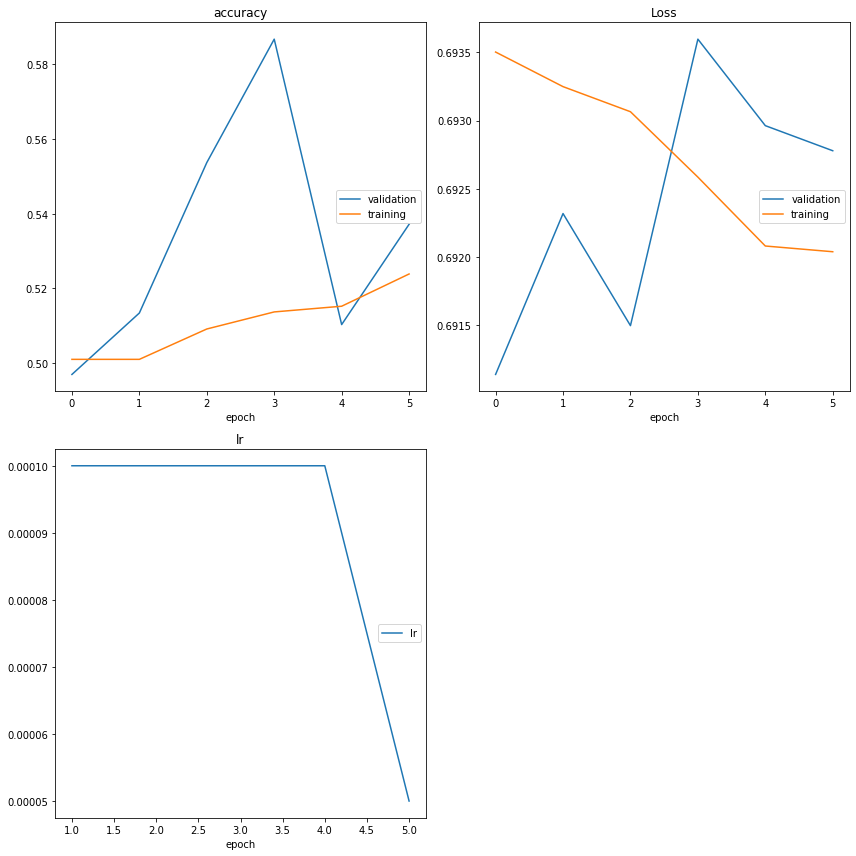

accuracy
	validation       	 (min:    0.497, max:    0.587, cur:    0.537)
	training         	 (min:    0.501, max:    0.524, cur:    0.524)
Loss
	validation       	 (min:    0.691, max:    0.694, cur:    0.693)
	training         	 (min:    0.692, max:    0.694, cur:    0.692)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)
Processing time: 46.8356568257014


In [21]:
start = time.time()

model.fit_generator(train_generator,  steps_per_epoch = NB_TRAIN_IMG // BATCH_SIZE,  epochs = 10, workers = 8,
                    validation_data = valid_generator, validation_steps = NB_VALID_IMG // BATCH_SIZE,
                    callbacks = [PlotLossesKeras(),
                                 EarlyStopping(monitor = 'val_loss', patience = 5),
                                 ReduceLROnPlateau(monitor = 'val_loss', patience = 3, factor = 1/2)])

end = time.time()
print('Processing time:', (end - start) / 60)

In [22]:
model.save("own_trained_CNN.h5")

#### Evaluation on test set

In [23]:
loss, acc = model.evaluate_generator(test_generator, steps = len(test_generator), verbose = 0, workers = 8)
print('Accuracy on test set:', acc)

Accuracy on test set: 0.5734999775886536


### No wonder our predictions are so bad - took 45 mins to train only the 5 epochs on my computer

Spoiler alert: transfer learning **test accuracy is 97.25%**

We can really improve accuracy if all we need to do is just take a pre-trained accurate model, and use it as our first n layers. This process is called **transfer learning** and Keras ahs built in SoTA models to leverage

<img src='https://pennylane.ai/qml/_images/transfer_learning_general.png' width = 500>

In [40]:
from keras.applications import InceptionV3
from keras.layers import Input

In [65]:
input_tensor = Input(shape = (300, 300, 3))

base_model = InceptionV3(weights = 'imagenet', include_top = False, input_tensor = input_tensor)

for layer in base_model.layers:
    layer.trainable = False

add_model = Sequential()
add_model.add(base_model)
add_model.add(GlobalAveragePooling2D())
add_model.add(Dropout(0.5))
#add_model.add(Dense(32, activation = 'relu'))
#add_model.add(Dropout(0.5))
add_model.add(Dense(1, activation = 'sigmoid'))

model = add_model    
    
model.compile(loss = 'binary_crossentropy', optimizer = RMSprop(lr = 0.0001), metrics = ['accuracy'])

In [66]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


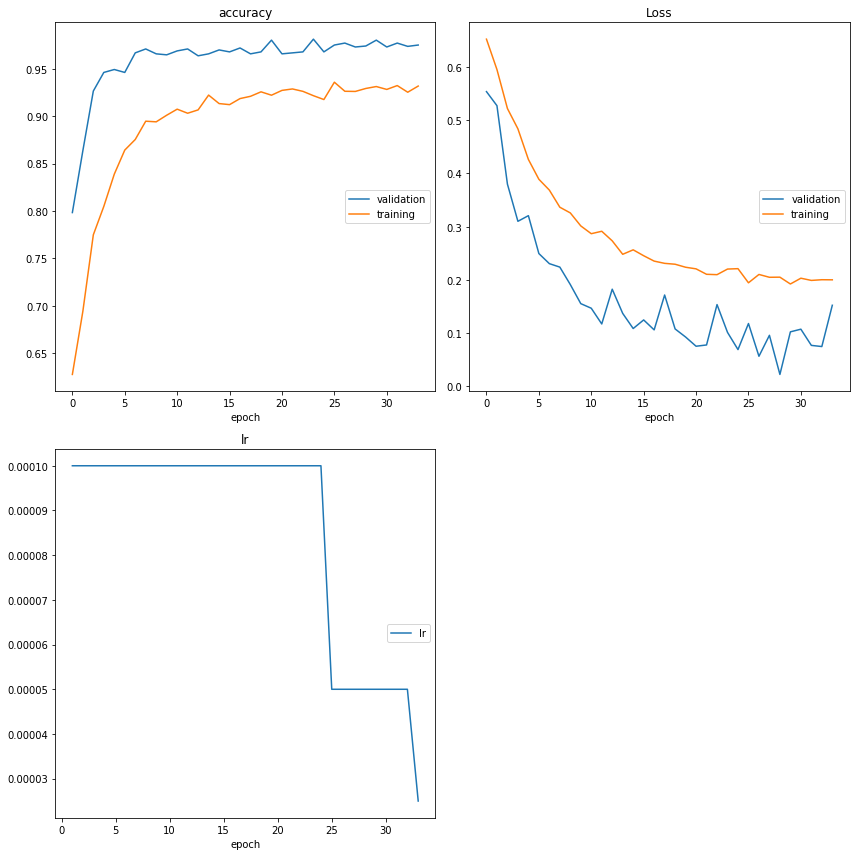

accuracy
	validation       	 (min:    0.798, max:    0.981, cur:    0.975)
	training         	 (min:    0.628, max:    0.936, cur:    0.932)
Loss
	validation       	 (min:    0.023, max:    0.554, cur:    0.152)
	training         	 (min:    0.192, max:    0.652, cur:    0.200)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)
Processing time: 479.5552586078644


In [67]:
start = time.time()

model.fit_generator(train_generator,  steps_per_epoch = NB_TRAIN_IMG // BATCH_SIZE,  epochs = 50, workers = 8,
                    validation_data = valid_generator, validation_steps = NB_VALID_IMG // BATCH_SIZE,
                    callbacks = [PlotLossesKeras(),
                                 EarlyStopping(monitor = 'val_loss', patience = 5),
                                 ReduceLROnPlateau(monitor = 'val_loss', patience = 3, factor = 1/2)])

end = time.time()
print('Processing time:', (end - start) / 60)

In [68]:
#model.save("transfer_trained_CNN.h5")

#### Evaluate transfer model on test set

In [69]:
loss, acc = model.evaluate_generator(test_generator, steps = len(test_generator), verbose = 0, workers = 8)
print('Accuracy on test set:', acc)

Accuracy on test set: 0.9725000262260437


### WOOW 97.25% accuracy on test set! 

#### Showcase a couple of predictions
I will create one more directory, which will contain 5-5 images of cats and dogs. Let's see the probabilities we prdict for each image

In [74]:
predictions_gen = ImageDataGenerator(rescale = 1./255)
predictions_generator = predictions_gen.flow_from_directory('data/make_predictions_on_these/', batch_size = 1, target_size = (300, 300), shuffle = False, class_mode = 'binary')

Found 9 images belonging to 1 classes.


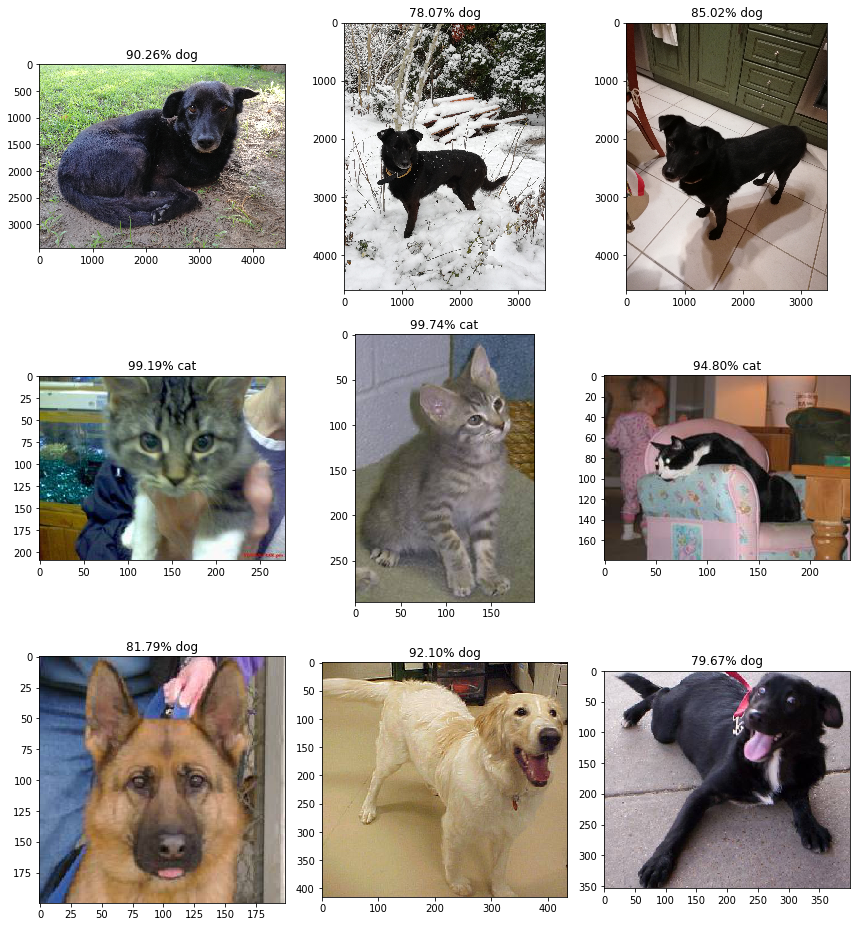

In [75]:
probabilities = model.predict_generator(predictions_generator, len(predictions_generator), workers = 8)
k = 0
plt.figure(figsize = (12, 13))

for index, probability in enumerate(probabilities):
    
    k += 1
    plt.subplot(3, 3, k)
    
    image_path = 'data/make_predictions_on_these/' + "/" + predictions_generator.filenames[index]
    plt.imshow(plt.imread(image_path))
    
    if probability > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% dog")
        
    else:
        plt.title("%.2f" % ((1-probability[0])*100) + "% cat")
        
    plt.tight_layout() 

### At what %-point should we cut off our labeling?

Accuracy is calcualted @ 50% which in a balanced situation is not a wrong way to go. But lowering / increasing the cutoff may result in better FPR / FNR numbers

In [116]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score

def plot_fpr_fnr(model_name, y_pred, y_true):
    
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    fnr = 1 - tpr

    plt.figure(figsize = (9, 4))
    sns.lineplot(thresholds, fpr, label = 'FPR')
    sns.lineplot(thresholds, fnr, label = 'FNR')
    plt.xlim(0, 1)
    plt.xticks(np.arange(0, 1.01, 0.05), fontsize = 8)
    plt.yticks(np.arange(0, 1.01, 0.1), fontsize = 8)
    plt.title('FPR and FNR plots for ' + model_name + '\n')
    plt.xlabel('Thresholds')
    plt.ylabel('Rates')
    plt.grid(linestyle = "--", color = 'black', alpha = 1/3, linewidth = 1/2)
    plt.show()
    
    
def plot_roc_auc(model_name, y_pred, y_true):
    
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    
    plt.figure(figsize = (9, 4))
    sns.lineplot(fpr, tpr, color = 'red', label = 'ROC curve (area = %0.5f)' % auc(fpr, tpr))
    sns.lineplot([0, 1], [0, 1], color = 'black')
    plt.xlim(0, 1)
    plt.xticks(np.arange(0, 1.01, 0.05), fontsize = 8)
    plt.yticks(np.arange(0, 1.01, 0.1), fontsize = 8)
    plt.title('ROC curve and AUC for ' + model_name + '\n')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.grid(linestyle = "--", color = 'black', alpha = 1/3, linewidth = 1/2)
    plt.show()
    
    
def print_confusion_matrix(model_name, threshold, y_pred, y_true):
    
    y_pred = test_predictions > threshold
    
    unnormalized_confusion_matrix = pd.DataFrame(confusion_matrix(y_true, y_pred, normalize = None), 
                 columns = pd.MultiIndex.from_tuples([('PREDICTED', 'cat'), ('PREDICTED', 'dog')]),
                 index = pd.MultiIndex.from_tuples([('TRUE', 'cat'), ('TRUE', 'dog')]))

    normalized_confusion_matrix = pd.DataFrame(confusion_matrix(y_true, y_pred, normalize = 'true'), 
                 columns = pd.MultiIndex.from_tuples([('PREDICTED', 'cat'), ('PREDICTED', 'dog')]),
                 index = pd.MultiIndex.from_tuples([('TRUE', 'cat'), ('TRUE', 'dog')]))
    
    print('Confusion matrices for', model_name, 'at threshold', threshold, '\n')

    print(unnormalized_confusion_matrix)
    print('\n')
    print(normalized_confusion_matrix)

In [85]:
test_predictions = model.predict_generator(test_generator)

In [88]:
test_true_labels = test_generator.classes

print('Num of predictions:', len(test_predictions))
print('Num of true labels:', len(test_true_labels))

Num of predictions: 2000
Num of true labels: 2000


#### FPR-FNR plots, ROC-AUC, confusion matrices with different thresholds

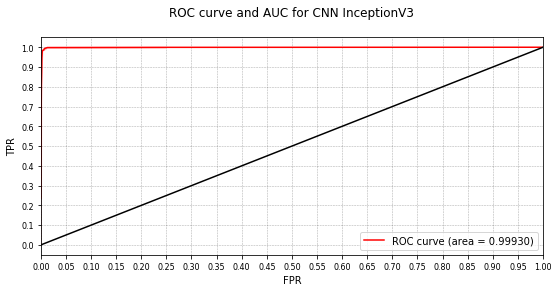

In [97]:
plot_roc_auc('CNN InceptionV3', test_predictions, test_true_labels)

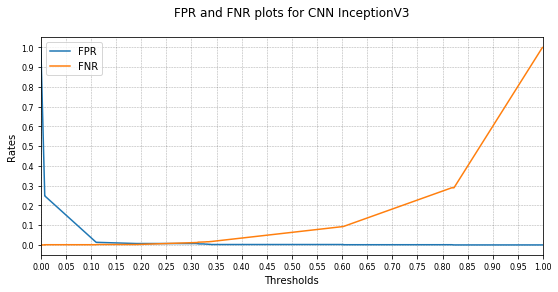

In [94]:
plot_fpr_fnr('CNN InceptionV3', test_predictions, test_true_labels)

Seems like I need to set the threshold around 20% to achieve lowest FPR and FNR

In [228]:
print_confusion_matrix('CNN InceptionV3', 0.17, test_predictions, test_true_labels)

Confusion matrices for CNN InceptionV3 at threshold 0.17 

         PREDICTED     
               cat  dog
TRUE cat       993    7
     dog         2  998


         PREDICTED       
               cat    dog
TRUE cat     0.993  0.007
     dog     0.002  0.998


#### Changing the 50% threshold to 17% results in a huge accuracy improvement

In [118]:
print('Accuracy at 50%:', accuracy_score(test_true_labels, test_predictions > 0.5))
print('Accuracy at 17%:', accuracy_score(test_true_labels, test_predictions > 0.17))

Accuracy at 50%: 0.9725
Accuracy at 17%: 0.9955


### So our *real* test accuracy is 99.55% !!
#### What are these 9 animals (2 dogs, 7 cats) that we're predicting incorrectly?

Here I expect images of dogs / cats in weird lighting, positions, from weird angles, otherwise the model should be able to differentiate between the two species

In [198]:
test_true_vs_pred = np.vstack((test_true_labels, np.reshape(test_predictions, (2000,)) > 0.17, np.reshape(test_predictions, (2000,)))).T
test_true_vs_pred.shape

(2000, 3)

In [203]:
wrong_predictions = []

for index, prediction in enumerate(test_true_vs_pred):
    if prediction[0] != prediction[1]:
        print(index, prediction)
        wrong_predictions.append(index)

7 [0.         1.         0.60221821]
32 [0.         1.         0.31307071]
767 [0.         1.         0.33058563]
837 [0.         1.         0.32517511]
915 [0.         1.         0.33725435]
933 [0.         1.         0.30934951]
957 [0.         1.         0.81819594]
1122 [1.         0.         0.00782815]
1795 [1.         0.         0.11026864]


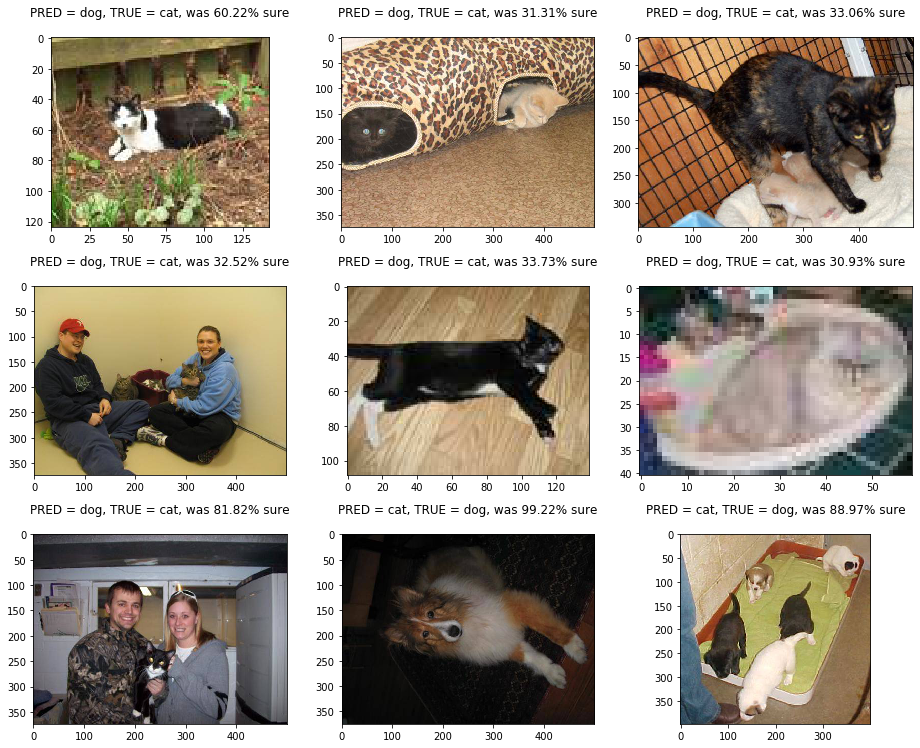

In [226]:
k = 0
plt.figure(figsize = (13, 10.5))

for i in wrong_predictions:
    
    k += 1
    plt.subplot(3, 3, k)
    
    image_path = 'data/test/' + test_generator.filenames[i]
    plt.imshow(plt.imread(image_path))
    
    true_vs_pred = test_true_vs_pred[i]
    
    if true_vs_pred[0] == 0:
        plt.title('PRED = dog, TRUE = cat, was ' + str(round(true_vs_pred[2] * 100, 2)) + '% sure\n')
        
    else:
        plt.title('PRED = cat, TRUE = dog, was ' + str(round((1 - true_vs_pred[2]) * 100, 2)) + '% sure\n')
        
    plt.tight_layout() 

Due to the 17% cutoff, there are more false positives (dog class is 1, so predicting 1 while true label is cat - 0). But using this cutoff, the overall amount of errors is the smallest. In this case it does not matter if we make false positive or false negative errors, so choosing the optimal 17% was the right thing to do

### Most interesting part: explaining the model 
What did the model **look for in the photo** to make the classification? For this we can use Class Activation Maps, that basically create a heatmap on top of the photos to tell us what was *important* in them

<img src='https://miro.medium.com/max/1186/0*D4FATkIeWp61o9zo.jpg' width = 600>

We should be able to see something similar to this :) 